<a href="https://colab.research.google.com/github/jyotisman-ds/TensorFlow_projects/blob/main/Beans_fullCalssifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import numpy as np

## defining augmentations

def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x
'''
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x
'''

def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(150,150))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    #choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time

    # tf.cond(choice < 0.5, lambda: tf.cast(x, tf.float32), lambda: random_crop(x))

    return random_crop(x)

In [20]:
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

beans, info = tfds.load('beans', with_info=True, as_supervised=True)

train_ds = beans['train']
valid_ds = beans['validation']
test_ds = beans['test']

num_classes = info.features['label'].num_classes


def resize_normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = tf.image.resize(image, [150, 150], method='nearest')
  return tf.cast(image, tf.float32) / 255., label


train_ds = train_ds.map(resize_normalize_img)
valid_ds = valid_ds.map(resize_normalize_img)
test_ds = test_ds.map(resize_normalize_img)


def flip_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  if tf.random.uniform([], 0, 1) > 0.2:
      return flip(image), label
  else:
    return image, label

def rotate_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  if tf.random.uniform([], 0, 1) > 0.2:
      return rotate(image), label
  else:
    return image, label

def zoom_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  if tf.random.uniform([], 0, 1) > 0.2:
      return zoom(image), label
  else:
    return image, label

augmentations = [flip_img, zoom_img, rotate_img]

for f in augmentations:
    train_ds = train_ds.map(f, num_parallel_calls=2)

def clip_dataset(img, label):
    return tf.clip_by_value(img, 0, 1), label

train_ds = train_ds.map(clip_dataset)


'''
# Add augmentations
augmentations = [flip, color, zoom, rotate]

for f in augmentations:
    dataset = train_ds.map(lambda x: tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: (f(x[0]),x[1]), lambda: x), num_parallel_calls=4)
dataset = dataset.map(lambda x: (tf.clip_by_value(x[0], 0, 1), x[1]))


#plot_images(dataset, n_images=8, samples_per_image=10)
'''


'\n# Add augmentations\naugmentations = [flip, color, zoom, rotate]\n\nfor f in augmentations:\n    dataset = train_ds.map(lambda x: tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: (f(x[0]),x[1]), lambda: x), num_parallel_calls=4)\ndataset = dataset.map(lambda x: (tf.clip_by_value(x[0], 0, 1), x[1]))\n\n\n#plot_images(dataset, n_images=8, samples_per_image=10)\n'

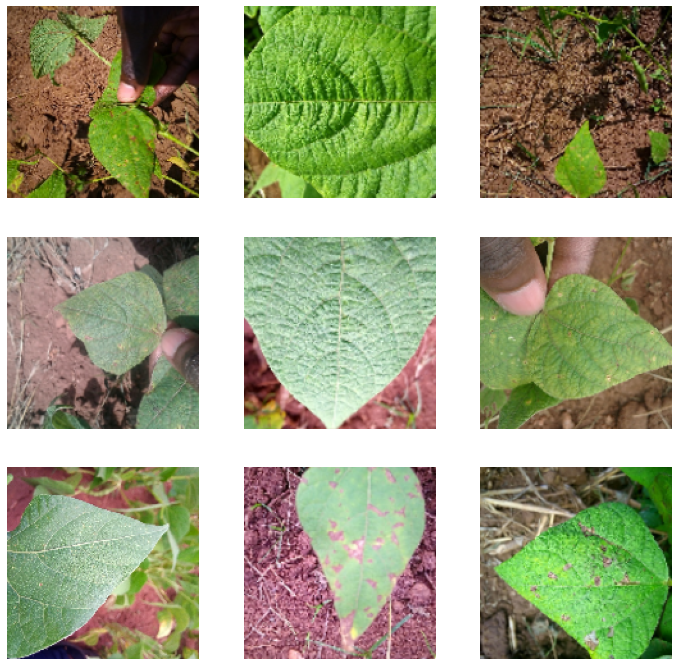

In [21]:
ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
count = 0
for image, _ in train_ds.take(100).repeat(5).shuffle(400).as_numpy_iterator():
     if count >= 9:
         break
     plt.subplot(nrows,ncols,count+1).axis('Off')
     plt.imshow(image)
     count+=1
plt.show()

In [22]:
# train_ds = train_ds.map(resize_normalize_img)
# valid_ds = valid_ds.map(resize_normalize_img)
# test_ds = test_ds.map(resize_normalize_img)

train_ds = train_ds.repeat(5) #including augmented images

train_ds = train_ds.shuffle(100000)
train_ds = train_ds.batch(256).prefetch(1)

model = keras.Sequential([keras.layers.Conv2D(16, (3,3), activation = 'relu',input_shape = (150,150,3)),
                          keras.layers.MaxPooling2D(2,2),
                          keras.layers.Conv2D(32,(3,3), activation = 'relu'),
                          keras.layers.MaxPooling2D(2,2),
                          keras.layers.Dropout(0.3),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(num_classes, activation='softmax')
                          ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

'''
history = model.fit(training_images,
                    training_labels,
                    batch_size = 32,
                    epochs = 5,
                    validation_data = (validation_images,validation_labels)
                    )
'''

history = model.fit(train_ds,
                    epochs = 50,
                    validation_data = valid_ds.batch(info.splits['validation'].num_examples)
                    )

model.evaluate(test_ds.batch(info.splits['test'].num_examples))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

[0.42321571707725525, 0.875]

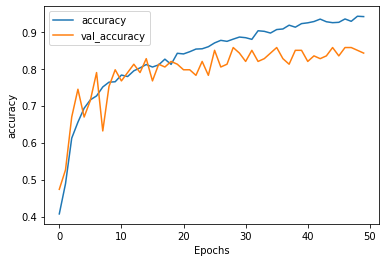

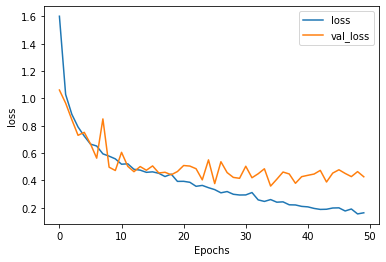

In [23]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')